## Tensorflow Probability - Linear Models with Uncertainty  
### Day 6/100 Days of TensorFlow Probability  

Today, I will continue to explore ways to estimate linear models using tensorflow probability (tfp). In the previous notebook, I used the `tfp.glm.fit()` api, which returned point estimates. However, there were a few things that I wanted to tidy up:  

  - `tfp.glm.fit()` seems to return point estimates only. This gives us a mean effect size, but not the uncertainty. I will explore the documentation a little more on this and see if there is a pre-built alternative, or whether this is more like sklearn in that respect.  
  - assuming that we can only get point estimates, I will use bootstrapping to estimate the uncertainty  
  - then, I will tidy up the prediction method from yesterday, which just wasn't correct  
  
If I have time, I intend to move on and look at plugging tfp into deep layers. I will expand on this later, time allowing.



Let's begin with simulating some new data. Similar to yesterday, our data will have known covariates, we'll incorporate seasonality and a bit of heteroscedasticity.  

[[ 0.40166528]
 [ 0.29879191]
 [-0.09915495]
 [ 2.5320589 ]]


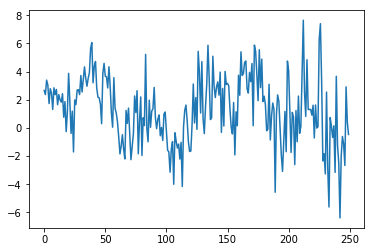

In [39]:
import collections
import numpy as np

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

try:
  tf.compat.v1.enable_eager_execution()
except ValueError:
  pass

import matplotlib.pyplot as plt

from __future__ import print_function


np.random.seed(1704)

# simulate 300 observations which follow a rough seasonal pattern
N = 250
X = np.transpose(
    np.matrix([
        np.ones(N),                                           # bias term 
        np.random.normal(2.7, 3, N),                          # feature one
        np.random.normal(-1.5, 1, N),                         # feature two
        0.45*np.cos(np.linspace(1, N, N) / 7.0) + \
            0.55*np.sin(np.linspace(1, N, N) / 21.0)          # seasonalilty
]))

# "ground truth" effects
# these are the parameters that we will attempt to recover
betas = np.matrix([
    np.random.normal(0.4, 0.1, N),                   # the intercept
    np.random.normal(0.3, 0.075, N),                    # effect of feature one
    np.random.normal(-0.1, 0.025, N),                  # effect of feature two
    np.random.normal(2.5, 0.75, N)                    # the seasonal effect
])
ground_truth_betas = np.mean(betas, axis=1)
print(ground_truth_betas)

# create a response variable, which is a function of our Xs + noise
y = np.mean(np.matmul(X, betas), axis=1)
y += np.random.normal(0, [0.15*np.sqrt(x) for x in range(N)], N)[:,np.newaxis]
y = tf.convert_to_tensor(y.reshape(N,)).numpy()[0]

plt.plot(range(N), y)
plt.show()

Today, I have increased the seasonal component a litte and reduced the noise. There's no real reason for this, it just makes our dataset a little more interesting to look at. I am still going to tackle this as a regression problem, I will assume that we know the covariates and the goal is to estimate the effects (and the uncertainty) to predict y.  

### Experiment One: point estimates  

Let's begin by reproducing our efforts from yesterday - we'll use `tfp.glm.fit()` to predict y and generate point estimates of the effect sizes. I will split the data into a training set (first 150 observations) and a test set (last 100 observations).

In [69]:
xtrain, xtest = [X[:150,::], X[150:,::]]
ytrain, ytest = [y[:150], y[150:]]


weights, yhat, is_converged, num_iter = tfp.glm.fit(
  model_matrix = xtrain,
  response = ytrain,
  model = tfp.glm.Normal()
)
print(weights)

for i in range(betas.shape[0]):
  print("{} (ground truth, estimated) = ({:.3f}, {:.3f})".format(
      'intercept' if i == 0 else 'feature {}'.format(i), 
      np.array(ground_truth_betas[i])[0][0],
      weights.numpy()[i]
  ))

tf.Tensor([ 0.22219276  0.30242504 -0.21769909  2.88791918], shape=(4,), dtype=float64)
intercept (ground truth, estimated) = (0.402, 0.222)
feature 1 (ground truth, estimated) = (0.299, 0.302)
feature 2 (ground truth, estimated) = (-0.099, -0.218)
feature 3 (ground truth, estimated) = (2.532, 2.888)


So, like we saw yesterday, the point estimates aren't bad. They are a little off, but they all appear to be in the right direction. It is perhaps no surprise that the seasonality has been well-recovered as this is the strongest effect. The heteroscedasticity is most likely to be the reason why our estimates aren't exactly returning the groupd truth.

Let's quickly look at the residuals and point-predictions for the training set:

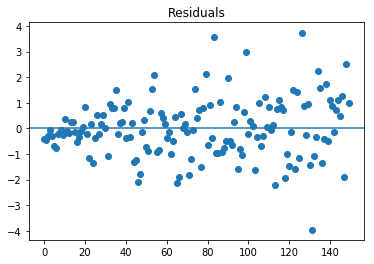

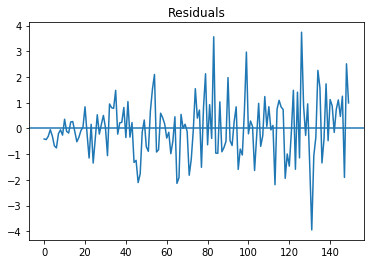

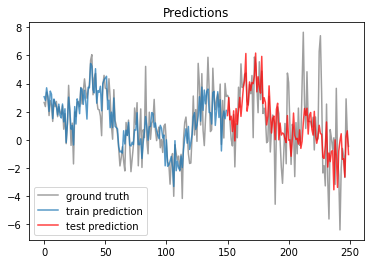

In [70]:
plt.scatter(range(150), ytrain - yhat)
plt.axhline(y = 0)
plt.title("Residuals")
plt.show()

plt.plot(range(150), ytrain - yhat)
plt.axhline(y = 0)
plt.title("Residuals")
plt.show()

yhat_test = np.matmul(xtest, np.array([0.222, 0.302, -0.218, 2.888])).reshape(100, 1)
plt.plot(range(N), y, color='grey', alpha=0.75, label='ground truth')
plt.plot(range(150), yhat, alpha=0.75, label='train prediction')
plt.plot(range(150,250), yhat_test, color='red', alpha=0.75, label='test prediction')
plt.title("Predictions")
plt.legend()
plt.show()

Our point predictions are actaully very good - this is entirely due to the strength of the seasonality. You can see how well our predictions match the center of the data. 

It's also immediately clear, that we're not capturing the variance in the data. I'd like our predictions to reflect more uncertainty later in this timeseries and address the heterscedasticity that is obvious in the residual plot.  

### Experiment Two: Regularisation  

Before I continue on with exploring uncertainties, let's see what happens when we add regularisation to our model... we should increase the bias and that should be increasingly obvious in our predictions:

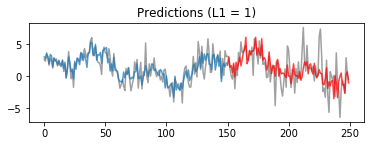

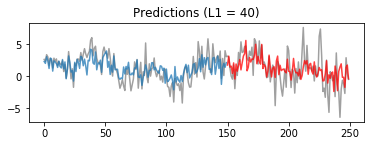

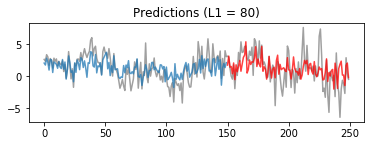

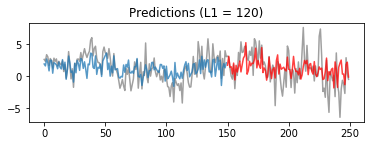

In [150]:
for i in [1, 40, 80, 120]:
  weights, yhat, is_converged, num_iter = tfp.glm.fit(
    model_matrix = xtrain,
    response = ytrain,
    model = tfp.glm.Normal(),
    l2_regularizer=i   # adding some regularisation to this
  )
  
#   plt.figure(2)
#   plt.subplot(212)
#   plt.plot(range(150), ytrain - yhat)
#   plt.axhline(y = 0)
#   plt.title("Residuals (L1 = {})".format(i))
#   plt.show()

  yhat_test = np.matmul(xtest, weights.numpy()).reshape(100, 1)
  plt.subplot(211)
  plt.plot(range(N), y, color='grey', alpha=0.75, label='ground truth')
  plt.plot(range(150), yhat, alpha=0.75, label='train prediction')
  plt.plot(range(150,250), yhat_test, color='red', alpha=0.75, label='test prediction')
  plt.title("Predictions (L1 = {})".format(i))
  plt.show()
  

This is for interesting more than anything. But it is clear, that the seasonality effect is dampened as we increase the regularisation. In effect, regularisation increases the bias in the predictions.  


### Experiment Three: Uncertainties via bootstrapp  

I can't see anyway that we can automatically get the uncertainties from `tfp.glm.fit()`. There certainly isn't anything in the [documentation](https://www.tensorflow.org/probability/api_docs/python/tfp/glm/fit), though perhaps if I understood the maths in [this notebook](https://colab.research.google.com/github/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Generalized_Linear_Models.ipynb#scrollTo=iXkxVBSmesjn) better, then perhaps we could derive the uncertainties.  

What we can do though, is use bootstrapping to train multiple models on bootstrapped datasets and then use these bootstrapped estimates to get a sense of the uncertainty. Let's do this. 

As before, I am going to train on the training set. However, this time I am going to randomly bootstrap 150 observations from our training data (with replacement). This should result in approx. a third of our training data being absent in each model and will hopefully give rise to some natural variation in the estimates.

I am going to define a couple of helper functions to make this easy, then we will run 10000 bootstrap samples.

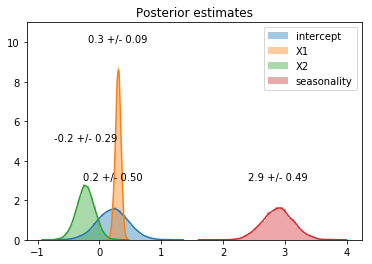

In [153]:
import seaborn as sns

def bootstrap(x, y):
  idx = np.random.choice(x.shape[0], 80, replace = True)
  
  return [x[idx, :], y[idx]]

def train(bootstrap_data = []):
  
  x, y = bootstrap_data
  
  weights, yhat, is_converged, num_iter = tfp.glm.fit(
    model_matrix = x,
    response = y,
    model = tfp.glm.Normal()
  )
  
  return weights.numpy()


# Bootstrapped estimates
K = 10000
bootstrap_weights = np.vstack([
    train(bootstrap(xtrain, ytrain)) for x in range(K)
])

# visualise the results
for i in range(bootstrap_weights.shape[1]):
  posterior = bootstrap_weights[:, i]
  
  label_ = 'intercept' if i == 0 else 'seasonality' if i == 3 else 'X{}'.format(i)
  sns.distplot(posterior, label = label_)
  plt.text(x = np.mean(posterior), y = [3, 10, 5, 3][i], 
           s = '{:.1f} +/- {:.2f}'.format(np.mean(posterior), 1.96*np.std(posterior)),
          horizontalalignment = 'center')
  plt.ylim((0, 11))


plt.legend()
plt.title("Posterior estimates")
plt.show()

This is a distinct improvement - now we have an estimate of the uncertainty. We can start to infer something from these:  

  - seasonality has the strongest effect, with a mean effect size of `2.9 +/- 0.44 (95% credible interval)`  
  - features one and two have much weaker effects at `-0.2 +/- 0.26 (95% credible interval)` and `0.3 +/- 0.08 (95% credible interval)` respectively. Feature One is clearly significant, but Feature Two is borderline. However, the majority of the posterior weight for Feature Two is less than zero, so I would be reasonably happy with this.  
  - the intercept term is effectively zero, with an uncertainty range which crosses zero (0.2 +/- 0.45 (95% credible interval)`)
  
(Note, the exact values above will change slightly each time this is run due to the randomness of the bootstrap sampling).


Armed with these uncertainties, we can now confidently say that the model has retrieved the true parameters for X1, X2 and the seasonality (the true parameters all fall within the 95% credible intervals). Similarly, the true intercept effect size is included in the 95% credible interval for the intercept estimate, however there is quite a lot of uncertainty in this estimate, so our evidence for a non-zero intercept is weak.

### Predictions with uncertainties  

We can now use these bootstrapped estimates to generate predictions. This should be relatively straight forward:

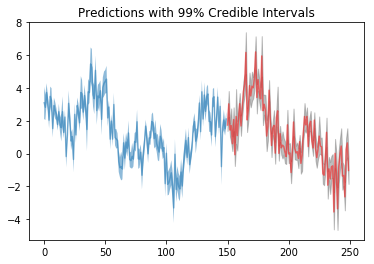

In [154]:
def predict(x, posterior):
  return np.matmul(x, np.transpose(posterior))

yhat_train = predict(xtrain, bootstrap_weights)
yhat_test = predict(xtest, bootstrap_weights)

# plot the training set predictions
# including the 99% credible interval
plt.plot(range(150), np.mean(yhat_train, axis=1).reshape(150,1), alpha=0.5)
plt.fill_between(range(150), 
                 np.quantile(yhat_train, q = 0.005, axis = 1),
                 np.quantile(yhat_train, q = 0.995, axis = 1), 
                 alpha=0.5)

# plot the test set predictions
# including the 99% credible itnervals
plt.plot(range(150,250), np.mean(yhat_test, axis=1).reshape(100,1), 
         color='red', alpha=0.5)
plt.fill_between(range(150,250), 
                 np.quantile(yhat_test, q = 0.005, axis = 1),
                 np.quantile(yhat_test, q = 0.995, axis = 1), 
                 color='grey', alpha=0.5)

plt.title("Predictions with 99% Credible Intervals")
plt.show()

The uncertainty intervals are surprisingly narrow. Let's zoom in on a small area so that we can better see them:

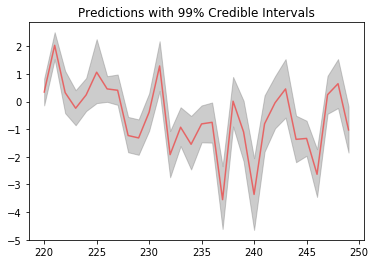

In [161]:
plt.plot(range(220,250), np.mean(yhat_test, axis=1).reshape(100,1)[70:], 
         alpha=0.5, color='red')
plt.fill_between(range(220,250), 
                 np.quantile(yhat_test, q = 0.005, axis = 1)[70:],
                 np.quantile(yhat_test, q = 0.995, axis = 1)[70:], 
                 color='grey', alpha=0.4)

plt.title("Predictions with 99% Credible Intervals")
plt.show()

### Final Thoughts  

Overall, I am pretty happy with this as an approach. It's worth noting that this *is not strictly a Bayesian approach*, seeing as we have used bootstrapping to derive the uncertainties. 

But, this is incredibly quick. It didn't take that logn to run 10000 bootstrap models up here in Colab. And we could speed this up by using a GPU or TPU backend. That's the advantage of using TensorFlow Probability here, rather than R's `glm()` or sklearn's `LinearRegression()`. 

However, moving forwards I need to start to take this into a proper Bayesian direction. This means I am going to have to dive a little deeper into tfp's syntax. Sigh - but that is the goal here, so I will have to really roll up my sleeves.